In [1]:
# #!/usr/bin python3
# -*- coding: utf-8 -*-
""" 
First, this script will parse the data from the tensorboard files found in the provided directory and store the result in a Dataframe object.
Then, it will go through the experiements folder and compare the results of each experience (test global cost) to SP, and so filter the experiments to good and bad given the parameters used.

sources : 
- https://laszukdawid.com/blog/2021/01/26/parsing-tensorboard-data-locally/
- https://stackoverflow.com/questions/37304461/tensorflow-importing-data-from-a-tensorboard-tfevent-file
"""
%matplotlib notebook
import tkinter
import matplotlib
import matplotlib.pyplot as plt

def convert_tb_data(root_dir, sort_by=None):
    """Convert local TensorBoard data into Pandas DataFrame.
    
    Function takes the root directory path and recursively parses
    all events data.    
    If the `sort_by` value is provided then it will use that column
    to sort values; typically `wall_time` or `step`.
    
    *Note* that the whole data is converted into a DataFrame.
    Depending on the data size this might take a while. If it takes
    too long then narrow it to some sub-directories.
    
    Paramters:
        root_dir: (str) path to root dir with tensorboard data.
        sort_by: (optional str) column name to sort by.
    
    Returns:
        pandas.DataFrame with [wall_time, name, step, value] columns.
    
    """
    import os
    import pandas as pd
    from tensorflow.python.summary.summary_iterator import summary_iterator
    from tensorflow.python.framework import tensor_util

    def convert_tfevent(filepath):
        return pd.DataFrame([
            parse_tfevent(e) for e in summary_iterator(filepath) if len(e.summary.value)
        ])

    def parse_tfevent(tfevent):
        if "hparams" in tfevent.summary.value[0].tag:
            scalar = 0.0
        else:
            scalar = tensor_util.MakeNdarray(tfevent.summary.value[0].tensor).item()
        return dict(
            wall_time=tfevent.wall_time,
            name=tfevent.summary.value[0].tag,
            step=tfevent.step,
            value=scalar,
        )
    
    columns_order = ['wall_time', 'name', 'step', 'value']
    
    out = []
    for (root, _, filenames) in os.walk(root_dir):
        for filename in filenames:
            if "events.out.tfevents" not in filename:
                continue
            file_full_path = os.path.join(root, filename)
            out.append(convert_tfevent(file_full_path))

    # Concatenate (and sort) all partial individual dataframes
    all_df = pd.concat(out)[columns_order]
    if sort_by is not None:
        all_df = all_df.sort_values(sort_by)
        
    return all_df.reset_index(drop=True)


In [92]:
if __name__ == '__main__':
    import numpy as np
    import pandas as pd
    import os
    import matplotlib.pyplot as plt
    import seaborn as sns 
    
    # Define the exps folder and evaluation metric name
    dir_path = "/home/redha/PRISMA/prisma/examples/abilene/5_nodes_full_mesh_overlay_experiment/to_test"
    eval_metrics = ["test_global_cost", "test_overlay_e2e_delay",  "test_overlay_loss_rate", "test_overlay_cost"]
    eval_metric_name = eval_metrics[0]
    # Retrive the SP results
    sp_temp_df = convert_tb_data(f"{dir_path}/sp")
    sp_df = pd.DataFrame([], columns=eval_metrics)
    for i, metric in enumerate(eval_metrics):
        sp_df[metric] = np.array(sp_temp_df[sp_temp_df.name == eval_metric_name].sort_values("step").value.values, dtype=float)
    sp_values = sp_df[eval_metric_name].values
    
    # Retrive the SP results
    opt_temp_df = convert_tb_data(f"{dir_path}/opt")
    opt_df = pd.DataFrame([], columns=eval_metrics)
    for i, metric in enumerate(eval_metrics):
        opt_df[metric] = np.array(opt_temp_df[opt_temp_df.name == eval_metric_name].sort_values("step").value.values, dtype=float)
    opt_values = opt_df[eval_metric_name].values
    
    # go through the folder and retrieve the results for each experiment
    folders_to_skip = ["saved_models", "good", "bad", "to_test", "a_test", "sp", "opt"]
    all_exps_results = []
    for exp_name in os.listdir(dir_path):
        
        # Skip the unrelevant folders 
        if exp_name in folders_to_skip:
            continue
        
        # Get the results for the experiment
        exp_temp_df = convert_tb_data(f"{dir_path}/{exp_name}")
        exp_df = pd.DataFrame([], columns=eval_metrics)
        for i, metric in enumerate(eval_metrics):
            exp_df[metric] = np.array(exp_temp_df[exp_temp_df.name == eval_metric_name].sort_values("step").value.values, dtype=float)
        exp_values = exp_df[eval_metric_name].values
        # Skip instances that don't have test results
        if len(exp_values) == 0:
            continue
        
        # Check if the results are better than SP 
        exp_flag = int(np.all(exp_values[2:5] < sp_values[2:5]))
        
        # Compute the MSE between the exp and the opt solution
        exp_mse = np.mean(np.abs((exp_values[2:5] - opt_values[2:5])/opt_values[2:5]))
        
        # Write everything to a dict
        exp_dict = dict(
            flag=exp_flag,
            mse=exp_mse,
            exp_values=exp_values
        )
        
        # Add the parameters of the experiment
        params_names = ["ping frequency", "train load", "use throughput",  "moving average window", "learning rate", "batch size", "exploration fixed"]
        params_markers = ["freq", "load", "dqn", "avg", "lr", "bs", "explo"]
        name_splitted = exp_name.split("_")
        for i, param_marker in enumerate(params_markers):
            param_name = params_names[i]
            param_value =  name_splitted[name_splitted.index(param_marker)+1]
            if param_name == "use throughput":
                if param_value == "with":
                    param_value = 1
                else:
                    param_value = 0
            if param_name == "exploration fixed":
                if param_value == "fixed":
                    param_value = 1
                else:
                    param_value = 0
            exp_dict[param_name] = float(param_value)
            
        # Append to the dataframe
        all_exps_results.append(pd.DataFrame(exp_dict))
        
    # Sort and fix the variables
    all_exps_df = pd.concat(all_exps_results)[params_names+["flag", "mse"]]
    all_exps_df.reset_index()
    print(all_exps_df)
    
    # Analyze the results
    # pd.plotting.scatter_matrix(all_exps_df,figsize=(20,15))
    

    ping frequency  train load  use throughput  moving average window  \
0            100.0         0.8             0.0                   10.0   
1            100.0         0.8             0.0                   10.0   
2            100.0         0.8             0.0                   10.0   
3            100.0         0.8             0.0                   10.0   
4            100.0         0.8             0.0                   10.0   
..             ...         ...             ...                    ...   
2             10.0         0.8             0.0                    1.0   
3             10.0         0.8             0.0                    1.0   
4             10.0         0.8             0.0                    1.0   
5             10.0         0.8             0.0                    1.0   
6             10.0         0.8             0.0                    1.0   

    learning rate  batch size  exploration fixed  flag       mse  
0          0.0001       512.0                1.0     0  

In [ ]:
    # for param_name in params_names:
    #     plt.figure(figsize=(16,7))
    #     sns.scatterplot(x=param_name, y="mse", data=all_exps_df, hue="flag")
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import scale

    
    # Data to treat 
    data = scale(all_exps_df[params_names+["mse"]].values)
    
    # check pca
    nb_components = 6
    pca = PCA(n_components=nb_components)
    pca_result = pca.fit_transform(data)
    components_names = []
    for i in  range(nb_components):
        all_exps_df[f'pca-{i}'] = pca_result[:,i]
        components_names.append(f'pca-{i}')
    


    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

        
    # Check the correlation between the principal components and the MSE values
    print(all_exps_df[components_names + ["mse"]].corr()["mse"])
    
    # plot the most correlated component 
    # plt.figure(figsize=(16,7))
    # # for i in range(1, nb_components+1):
    #     # ax = plt.subplot(int(nb_components/np.floor(np.sqrt(nb_components))),
    #     #             int(np.floor(np.sqrt(nb_components))),
    #     #             i)
    # sns.scatterplot(
    #     x="pca-0",y="mse",
    #     hue="flag",
    #     data=all_exps_df,
    #     alpha=0.5,
    # )

    
    
    # print the coefficient of the most correlated componenent
    for i,x in enumerate(params_names+["mse"]):
        print(x, pca.components_[0][i])
    print("done")
    

In [ ]:
    # Trying MCA
    # params_names.remove('use throughput')
    import prince
    mca = prince.MCA(n_components=nb_components,
                    copy=True,
                    check_input=True,
                    engine='auto',
                    random_state=42)
    X = all_exps_df[params_names + ["flag"]]
    for column in X.columns:
        X[column] = X[column].apply(str)
    # from sklearn.preprocessing import OneHotEncoder
    # encoder = OneHotEncoder(handle_unknown='ignore')

    # X = pd.DataFrame(encoder.fit_transform(all_exps_df[params_names]).toarray()) 
    # columns = []
    # for name in params_names:
    #     columns.extend([f"{name}-{x}" for x in all_exps_df[name].unique().tolist()])
    # X.columns = columns
    mca_components_names = []
    mca_result = mca.fit_transform(X).values
    for i in  range(nb_components):
        all_exps_df[f'mca-{i}'] = mca_result[:,i]
        mca_components_names.append(f'mca-{i}')
    
    print(all_exps_df[mca_components_names + ["mse"]].corr()["mse"])

    # ax = mca.plot_coordinates(
    #     X=X,
    #     ax=None,
    #     figsize=(6, 6),
    #     show_row_points=True,
    #     row_points_size=10,
    #     show_row_labels=False,
    #     show_column_points=True,
    #     column_points_size=30,
    #     show_column_labels=False,
    #     legend_n_cols=1
    #  )

    # ax.get_figure()
    # plt.show()

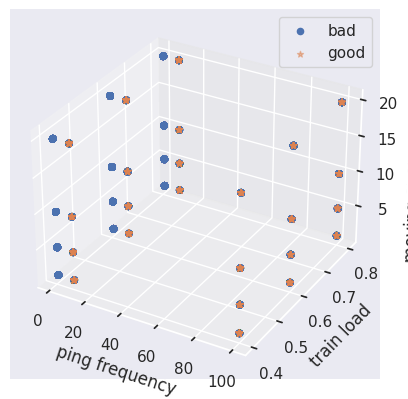

In [3]:
    from mpl_toolkits.mplot3d import Axes3D

    sns.set(style = "darkgrid")

    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    
    # compute the ratio of good vs bad experiments, by computing the mean of the flag for each unique value of the parameters
    # all_exps_df.groupby(['ping frequency', 'train load', 'moving average window', "flag"]).size().unstack()
    # all_exps_df = all_exps_df.fillna(0)
    # all_exps_df = all_exps_df.div(all_exps_df.sum(axis=1), axis=0) 

    x = all_exps_df[all_exps_df["flag"]==0.0]['ping frequency']
    y = all_exps_df[all_exps_df["flag"]==0.0]['train load']
    z = all_exps_df[all_exps_df["flag"]==0.0]["moving average window"]

    ax.set_xlabel('ping frequency')
    ax.set_ylabel('train load')
    ax.set_zlabel("moving average window")

    ax.scatter(x, y, z, label='bad')
    
    x = all_exps_df[all_exps_df["flag"]==1.0]['ping frequency']
    y = all_exps_df[all_exps_df["flag"]==1.0]['train load']
    z = all_exps_df[all_exps_df["flag"]==1.0]["moving average window"]
    ax.scatter(x, y, z, alpha=0.5, marker="*", label='good')
    
    plt.legend()
    plt.show()

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D


sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
df = all_exps_df[['ping frequency', 'train load', 'moving average window', "flag"]]
df = df.groupby(['ping frequency', 'train load', 'moving average window', "flag"]).size().unstack()
df.fillna(0, inplace=True)
df = df.div(df.sum(axis=1), axis=0)
df.reset_index(inplace=True)

x = df.values[:,0]
x[x==10]= 50
y = df.values[:,1]
z = df.values[:,2]
w = df.values[:,4]

z[z==20] = 15
ax.set_xticks([1, 50, 100], [1, 10, 100])
cmhot = plt.get_cmap("hot")
p = ax.scatter(x, y, z, c=w, cmap="Greys", s=40, edgecolors="grey")
cbar =plt.colorbar(p)
cbar.set_label('good experiments ratio')
ax.set_xlabel('ping frequency')
ax.set_ylabel('train load')
ax.set_zlabel("moving average window")

ax.set_zticks([1, 5, 10, 15], [1, 5, 10, 20])
ax.set_yticks([0.4, 0.6, 0.8], [0.4, 0.6, 0.8])


plt.title("The effect of the parameters on the good experiments ratio")
ax.view_init(30, 20)
plt.savefig("figures/3dscatter_parameters_analysis.png", dpi=300)
plt.savefig("figures/3dscatter_parameters_analysis.pdf")



NameError: name 'sns' is not defined

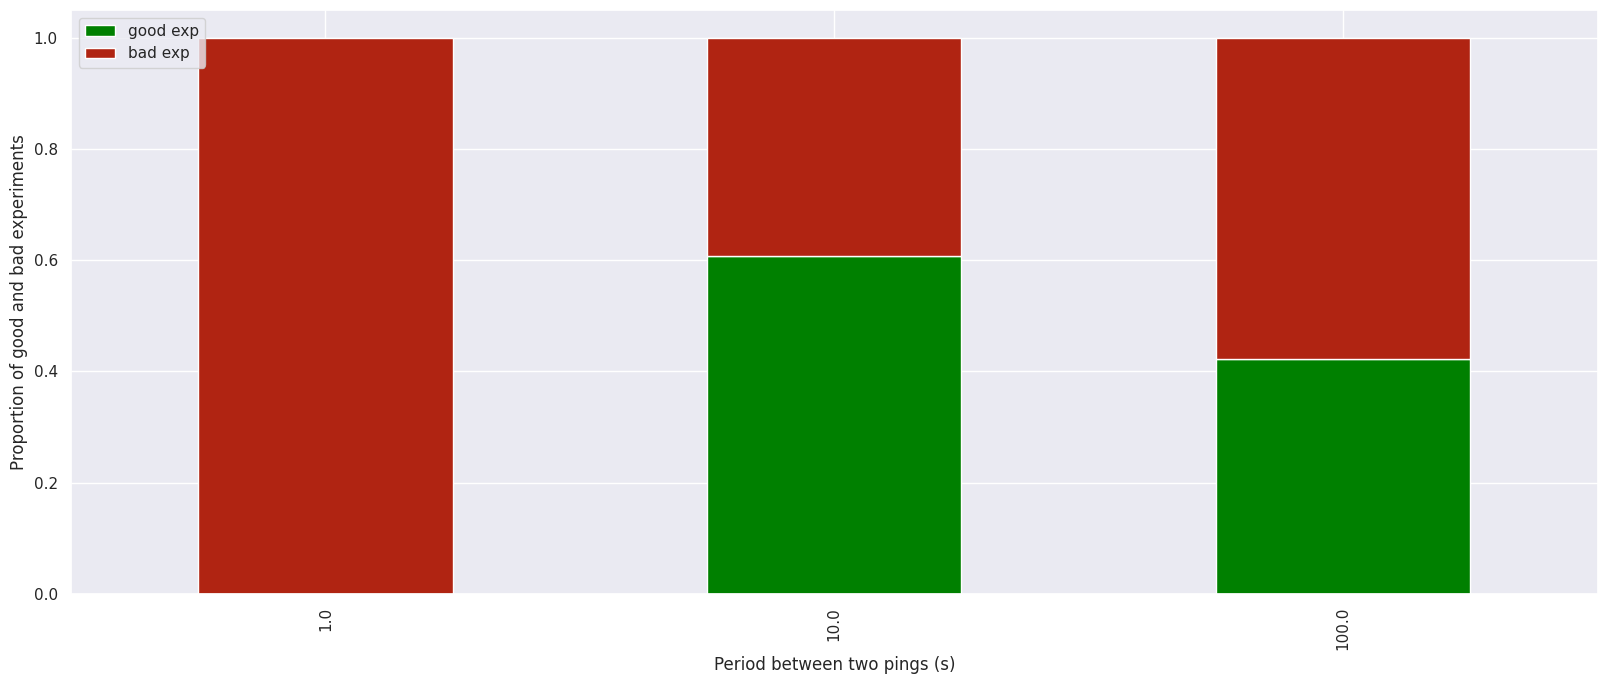

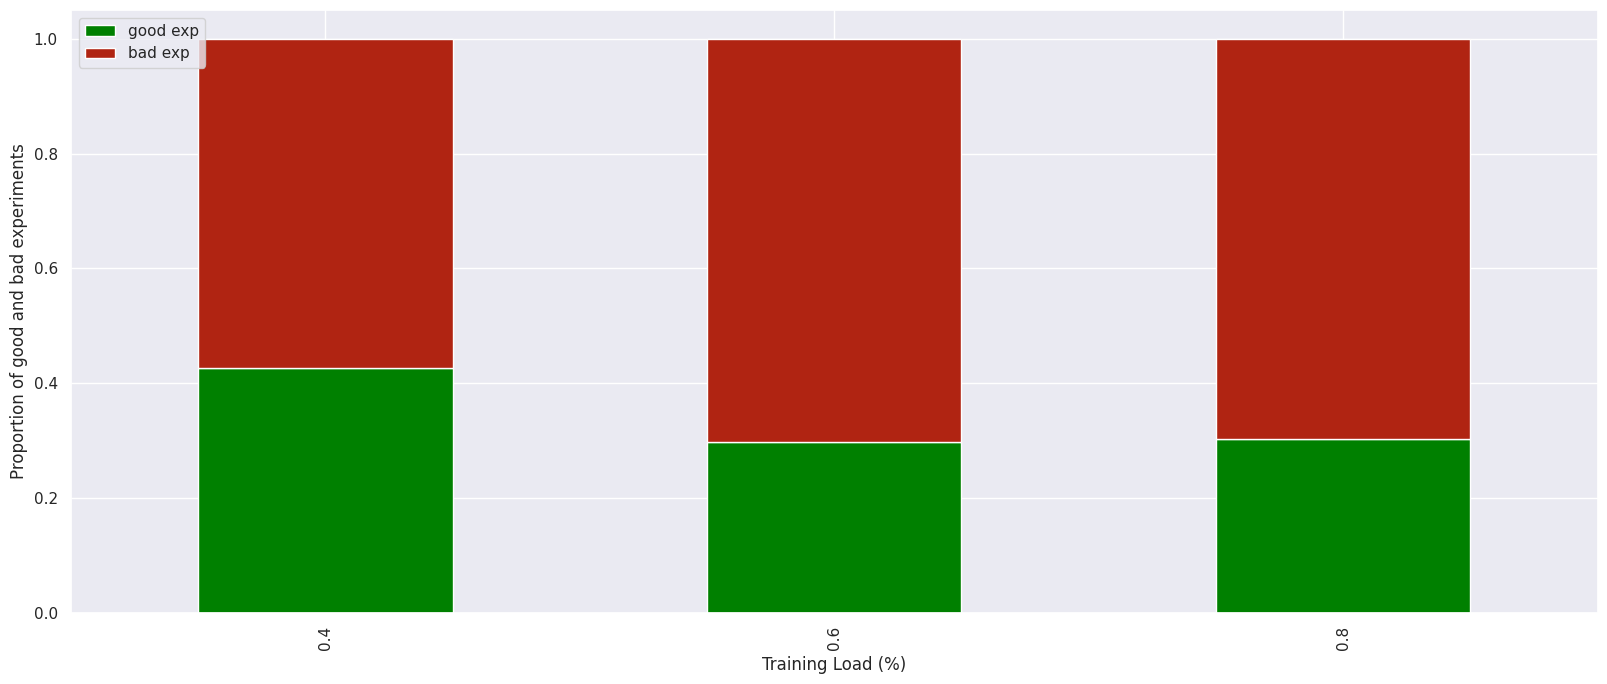

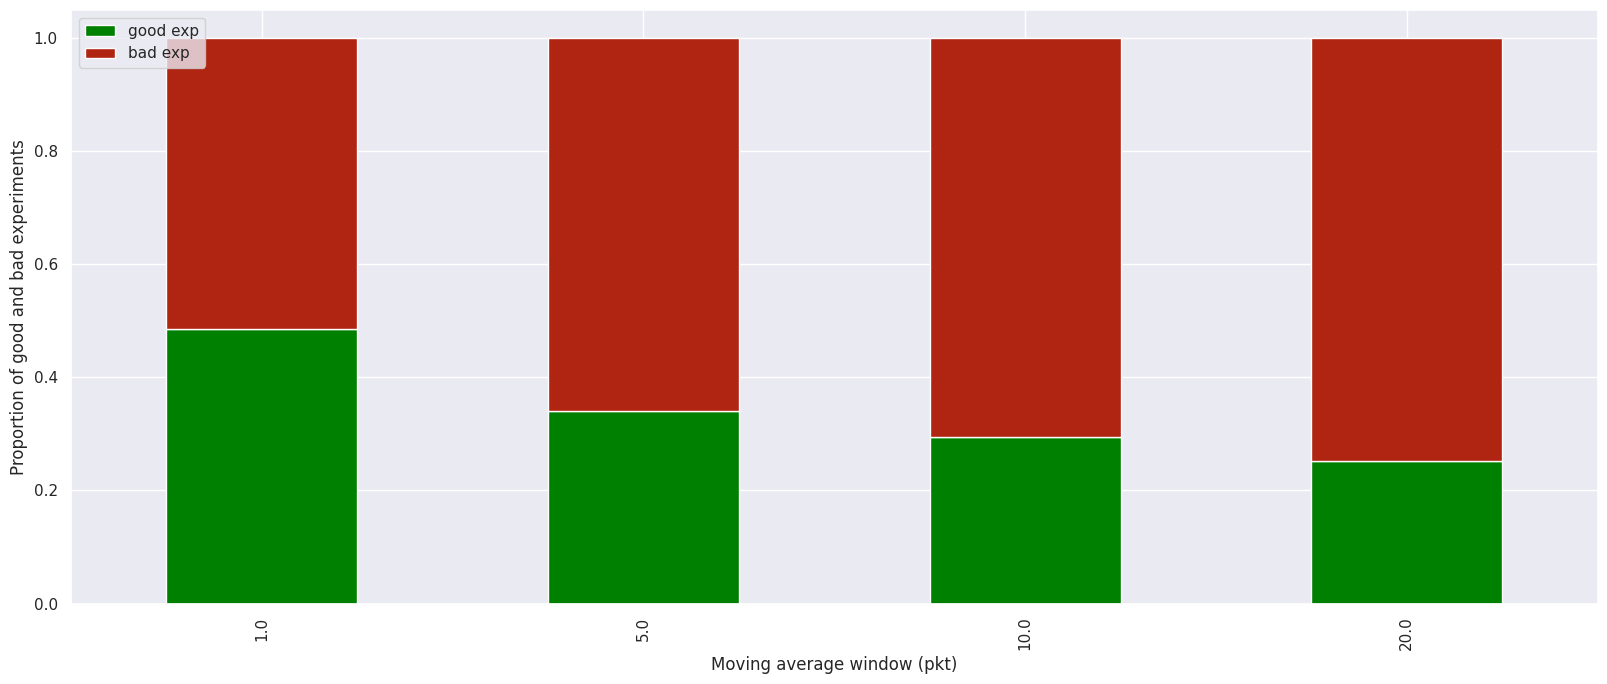

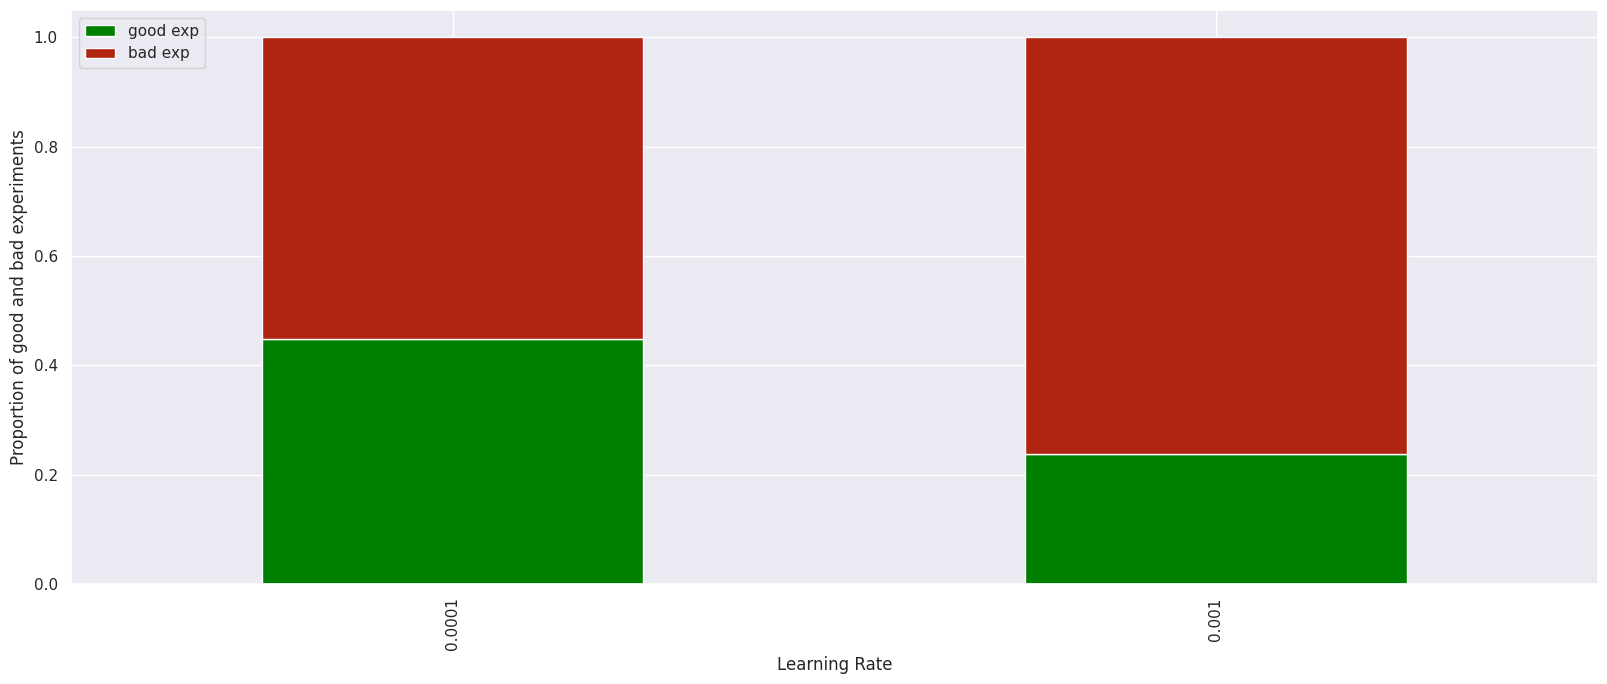

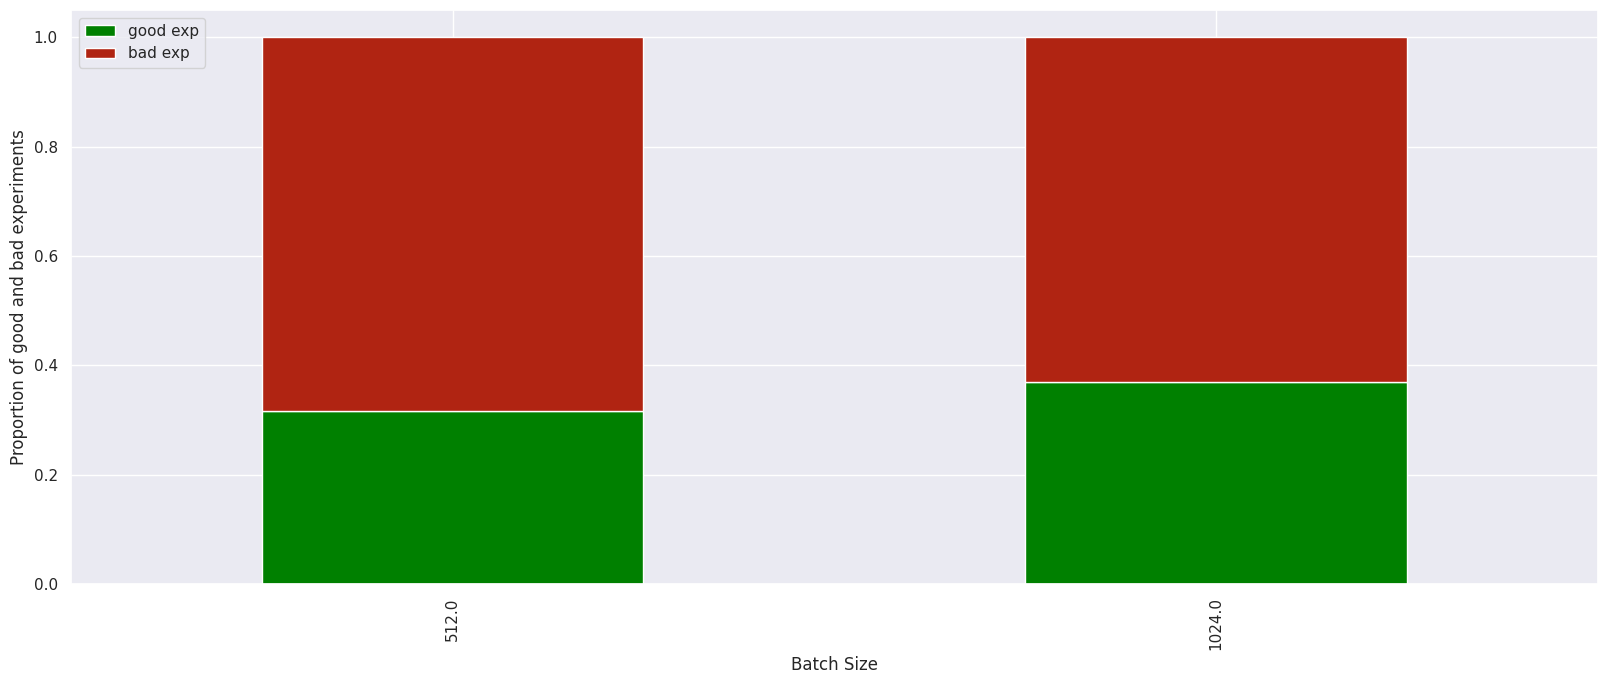

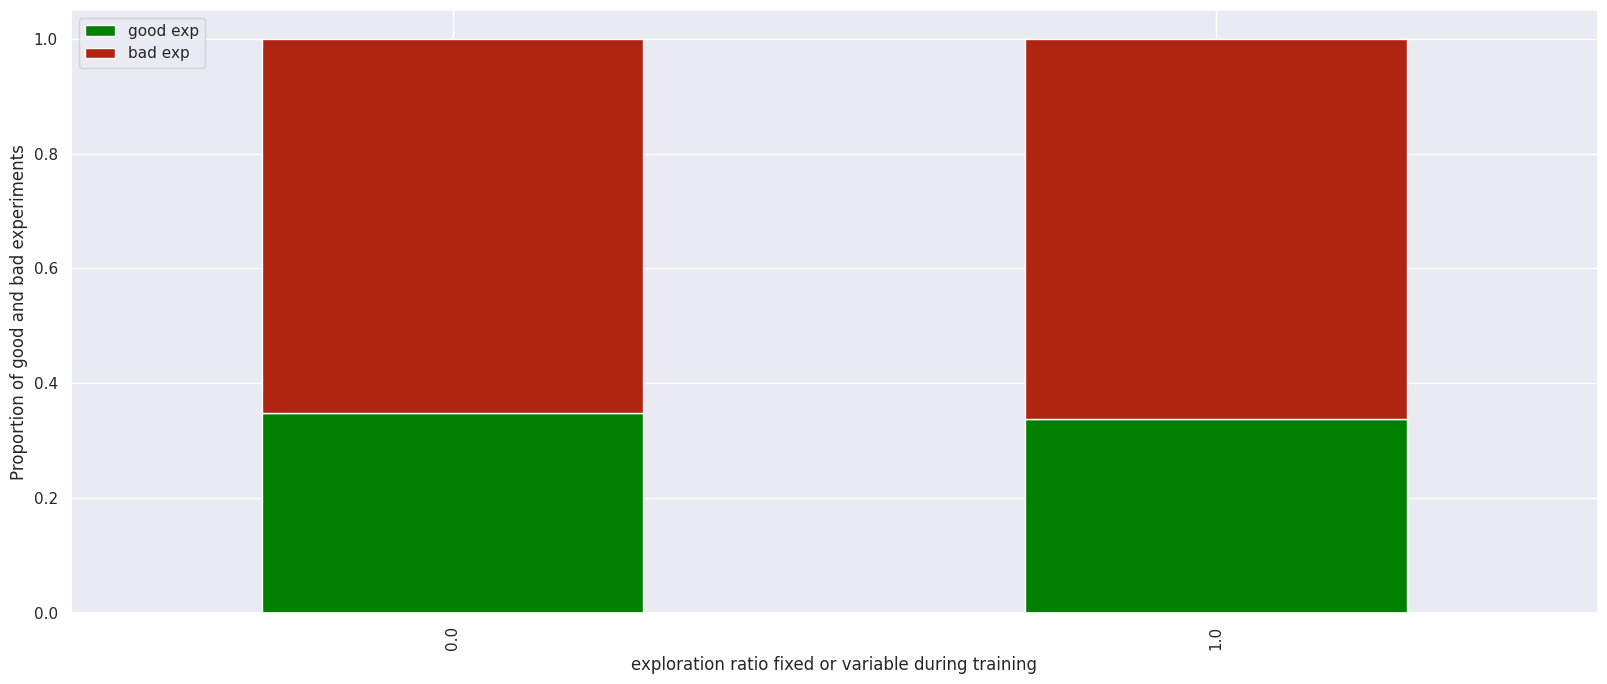

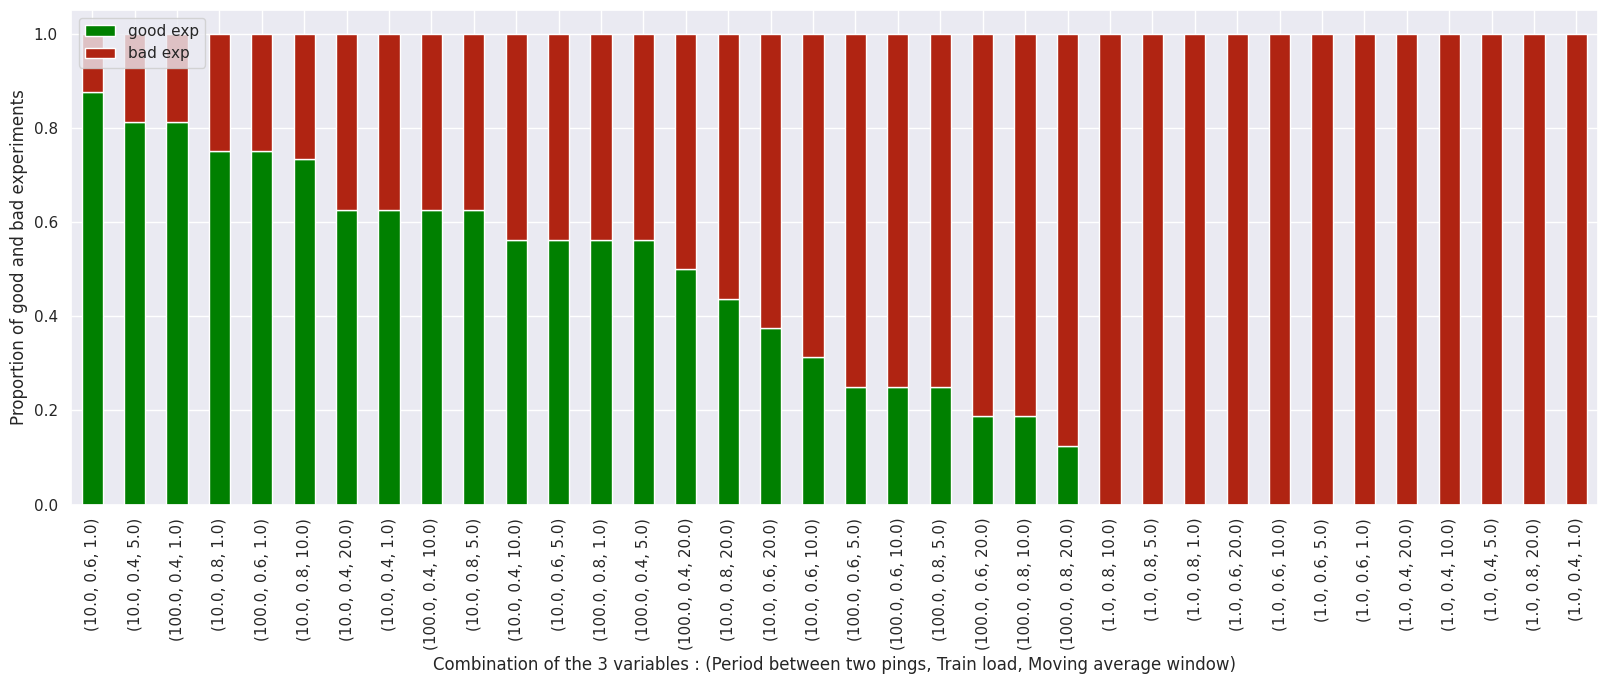

In [95]:
# for each of the variables : "ping frequency", "train load" and "moving average window", plot the proportion of having a "flag" = 1 or 0 in bar plots
def plot_bar(df, column, xlabel):
    df = df[[column, "flag"]]
    df = df.groupby([column, "flag"]).size().unstack()
    df = df.fillna(0)
    df = df.div(df.sum(axis=1), axis=0)
    df = df[[1.0, 0.0]]
    df.plot(kind="bar", stacked=True, figsize=(16,7), color=["green", "#b02412"])
    plt.legend(["good exp","bad exp"], loc="upper left")
    plt.tight_layout()
    plt.xlabel(xlabel)
    plt.ylabel("Proportion of good and bad experiments")
    plt.savefig("figures/barplot_"+column+".png", dpi=300)
    plt.savefig("figures/barplot_"+column+".pdf")
plot_bar(all_exps_df, "ping frequency", "Period between two pings (s)")
plot_bar(all_exps_df, "train load", "Training Load (%)")
plot_bar(all_exps_df, "moving average window", "Moving average window (pkt)")
plot_bar(all_exps_df, "learning rate", "Learning Rate")
plot_bar(all_exps_df, "batch size", "Batch Size")
plot_bar(all_exps_df, "exploration fixed", "exploration ratio fixed or variable during training") 
# same as above but have in the x axis all the combination of the unique values of the 3 variables and sort them by the higher count of "flag" = 0, and invert the proportion of "flag" = 1 and 0 by having flag = 1 on the top, add also the legend where you put that 0 is refering to bad experiments in red and 1 to good experiments in green and add tight layout and xlabel and ylabel
def plot_bar2(df, column1, column2, column3):
    df = df[[column1, column2, column3, "flag"]]
    df = df.groupby([column1, column2, column3, "flag"]).size().unstack()
    df = df.fillna(0)
    df = df.div(df.sum(axis=1), axis=0)
    df = df.sort_values(by=[0.0], ascending=True)
    df = df.reindex(columns=[1.0, 0.0])
    df.plot(kind="bar", stacked=True, figsize=(16,7), color=["green", "#b02412"])
    plt.legend(["good exp", "bad exp"], loc="upper left")
    plt.tight_layout()
    plt.xlabel("Combination of the 3 variables : (Period between two pings, Train load, Moving average window)")
    plt.ylabel("Proportion of good and bad experiments")
    plt.savefig("figures/barplot_"+column1+"_"+column2+"_"+column3+".png", dpi=300)
    plt.savefig("figures/barplot_"+column1+"_"+column2+"_"+column3+".pdf")
plot_bar2(all_exps_df, "ping frequency", "train load", "moving average window")

In [ ]:
# use 3DContour plot method to visualize the distribution of "mse" given the 3 variables, the x, y and z axis should be the 3 variables and the color should be the "mse", add the label for the x, y and z axis and add the title "mse distribution given the 3 variables"
def plot_3d_contour(df, column1, column2, column3):
    df = df[[column1, column2, column3, "mse"]]
    df = df.groupby([column1, column2, column3]).mean().reset_index()
    df = df.pivot_table(index=column1, columns=column2, values="mse")
    df = df.sort_index(ascending=False)
    df = df.sort_index(axis=1, ascending=False)
    df = df.fillna(0)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(df.columns, df.index, df.values, cmap='viridis')
    # add labels
    ax.set_xlabel(column1)
    ax.set_ylabel(column2)
    ax.set_zlabel(column3)
    # add colorbar
    plt.tight_layout()
    plt.legend()
    
    ax.set_title("mse distribution given the 3 variables")
    plt.show()

# # same as above but use scatter plot instead of 3DContour plot
